# Coverage of MULTIPLIER LV

The goal of this notebook is to examine why genes were found to be generic. Specifically, this notebook is trying to answer the question: Are generic genes found in more multiplier latent variables compared to specific genes?

The PLIER model performs a matrix factorization of gene expression data to get two matrices: loadings (Z) and latent matrix (B). The loadings (Z) are constrained to aligned with curated pathways and gene sets specified by prior knowledge [Figure 1B of Traoni et. al.](). This ensure that some but not all latent variables capture known biology. The way PLIER does this is by applying a penalty such that the individual latent variables represent a few gene sets in order to make the latent variables more interpretable. Ideally there would be one latent variable associated with one gene set unambiguously.

While the PLIER model was trained on specific datasets, MULTIPLIER extended this approach to all of recount2, where the latent variables should correspond to specific pathways or gene sets of interest. Therefore, we will look at the coverage of generic genes versus specific genes across these MULTIPLIER latent variables.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import seaborn as sns

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from ponyo import utils
from generic_expression_patterns_modules import process

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/

In [2]:
# Get data directory containing gene summary data
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
data_dir = os.path.join(base_dir, "human_general_analysis")

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]

In [3]:
# Output file
output_figure_filename = "LV_coverage.svg"

## Get gene data

In [4]:
# Get all gene summary file paths
ls_data_files = process.get_gene_summary_files(data_dir)

In [5]:
# Identify generic and specific genes using z-score
# Z-score cutoff was found by calculating invnorm(0.05/17754). 
# To do this in python you can use the following code:
# from scipy.stats import norm
# norm.ppf((0.05/17754)/2)
# Here we are using a p-value = 0.05
# with a Bonferroni correction for 17754 tests, which are
# the number of P. aeruginosa genes

zscore_threshold = 4.68
ls_genes_out = process.get_generic_specific_genes(ls_data_files, zscore_threshold)

Reading data for /home/alexandra/Documents/Repos/generic-expression-patterns/human_general_analysis/generic_gene_summary_SRP012656_run2.tsv
(17754, 10)
No. of specific DEGs using z-score: 0
No. of generic DEGs using z-score: 17568
Reading data for /home/alexandra/Documents/Repos/generic-expression-patterns/human_general_analysis/generic_gene_summary_SRP012656.tsv
(17754, 10)
No. of specific DEGs using z-score: 2
No. of generic DEGs using z-score: 17566


## Get LV data and filter

In [6]:
# Load multiplier models
# Converted formatted pickle files (loaded using phenoplier environment) from
# https://github.com/greenelab/phenoplier/blob/master/nbs/01_preprocessing/005-multiplier_recount2_models.ipynb
# into .tsv files
# Raw data was downloaded from https://figshare.com/articles/recount_rpkm_RData/5716033/4
multiplier_model_summary = pd.read_csv("multiplier_model_summary.tsv", sep="\t", index_col=0, header=0)
multiplier_model_z = pd.read_csv("multiplier_model_z.tsv", sep="\t", index_col=0, header=0)

In [7]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


In [8]:
# Only select LVs that are signficantly associated with some pathways or gene set (i.e. FDR < 0.05)
multiplier_model_z_processed = process.process_multiplier_model_z(multiplier_model_z, multiplier_model_summary)

In [9]:
multiplier_model_z_processed.head()

,LV1,LV2,LV3,LV4,LV7,LV8,LV10,LV11,LV12,LV13,...,LV953,LV954,LV960,LV962,LV964,LV975,LV976,LV977,LV985,LV986
GAS6,0.000000,0.0,0.039438,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.010517,...,0.000000,0.071876,0.0,0.001723,0.000000,0.0,0.000000,0.000000,0.0,0.000000
MMP14,0.000000,0.0,0.000000,0.0,0.0,0.004904,2.423595,0.029450,0.000000,0.000000,...,0.782420,0.005874,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.014978
DSP,0.000000,0.0,0.000000,0.0,0.0,0.005718,0.000000,0.002028,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.007125,0.0,0.039673,0.008547,0.0,0.000000
MARCKSL1,0.305212,0.0,0.000000,0.0,0.0,0.000000,0.149471,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.541018,0.000000,0.0,0.000000
SPARC,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.014014,0.010638,1.461908,0.000000,...,0.234755,0.000000,0.0,0.306096,0.000000,0.0,0.000000,0.000000,0.0,0.122417


## Quick looks at the data

In [10]:
# Get a rough sense for how many genes contribute to a given LV
# (i.e. how many genes have a value > 0 for a given LV)
(multiplier_model_z > 0).sum()

LV1      3219
LV2      1886
LV3      2683
LV4      2951
LV5      1668
LV6      2168
LV7      2141
LV8      2425
LV9      3717
LV10     2042
LV11     1832
LV12     1563
LV13     1426
LV14     1603
LV15     3065
LV16     2850
LV17     2284
LV18     2177
LV19     2113
LV20     3593
LV21     2354
LV22     2241
LV23     2704
LV24     2416
LV25     2364
LV26     2064
LV27     2088
LV28     2961
LV29     1632
LV30     2778
         ... 
LV958    2618
LV959    2331
LV960    2043
LV961    2360
LV962    2436
LV963    3056
LV964    3539
LV965    2701
LV966    3725
LV967    1989
LV968    3372
LV969    2925
LV970    3168
LV971    2674
LV972    2503
LV973    2873
LV974    3761
LV975    2136
LV976    4128
LV977    2048
LV978    2888
LV979    3153
LV980    2539
LV981    2654
LV982    2385
LV983    2874
LV984    4605
LV985    3030
LV986    2663
LV987    4285
Length: 987, dtype: int64

In [11]:
# One off just to get a sense for how many genes are being compared
# Filter genes to only use those shared between our analysis and multiplier
# Check overlap between multiplier genes and our genes
multiplier_genes = list(multiplier_model_z.index)
our_genes = list(pd.read_csv(ls_data_files[0], sep="\t", index_col=0, header=0).index)
shared_genes = set(our_genes).intersection(multiplier_genes)

print(len(our_genes))
print(len(shared_genes))

17754
6374


## Gene coverage of LV

6372 0
6371 1


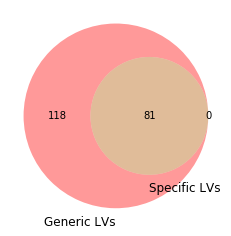

In [12]:
generic_cov_ls = []
specific_cov_ls = []

for ifile in range(len(ls_data_files)):
    generic_genes = ls_genes_out[ifile][0]
    specific_genes = ls_genes_out[ifile][1]
    
    # Only include those genes that are in multiplier otherwise will get NAs
    generic_genes_processed, specific_genes_processed = process.process_generic_specific_gene_lists(
        generic_genes, 
        specific_genes, 
        multiplier_model_z_processed
    )
    print(len(generic_genes_processed), len(specific_genes_processed))
    
    generic_cov_i, specific_cov_i = process.get_LV_coverage(
        generic_genes_processed,
        specific_genes_processed,
        multiplier_model_z_processed
    )
    
    generic_cov_ls += list(generic_cov_i)
    specific_cov_ls += list(specific_cov_i)
    
from matplotlib_venn import venn2
venn2([set(generic_cov_ls), set(specific_cov_ls)],
      set_labels=("Generic LVs", "Specific LVs")
     )

In [48]:
# Create table of unique generic LVs, unique specific LVs, shared LVs
process.create_LV_df(generic_cov_ls, specific_cov_ls, multiplier_model_summary)

No LVs in group: specific_only


In [14]:
# Find the number of generic and specific genes that have a nonzero contribution to LV
generic_cov = []
specific_cov = []
num_significant_LVs = multiplier_model_z_processed.shape[1]

for ifile in range(len(ls_data_files)):
    generic_genes = ls_genes_out[ifile][0]
    specific_genes = ls_genes_out[ifile][1]
    
    # Only include those genes that are in multiplier otherwise will get NAs
    generic_genes_processed, specific_genes_processed = process.process_generic_specific_gene_lists(
        generic_genes, 
        specific_genes, 
        multiplier_model_z_processed
    )
    print(len(generic_genes_processed), len(specific_genes_processed))
    
    generic_cov_i, specific_cov_i = process.get_LV_coverage(
        generic_genes_processed,
        specific_genes_processed,
        multiplier_model_z_processed
    )
    
    generic_cov.append(len(generic_cov_i)/num_significant_LVs)
    specific_cov.append(len(specific_cov_i)/num_significant_LVs)
    
gene_cov = pd.DataFrame({'Proportion of significantly associated LVs covered': generic_cov + specific_cov,
                         'gene type': ['generic']*len(ls_data_files) + ['specific']*len(ls_data_files) 
                      })

6372 0
6371 1


[1.0, 1.0]
[0.0, 0.40703517587939697]


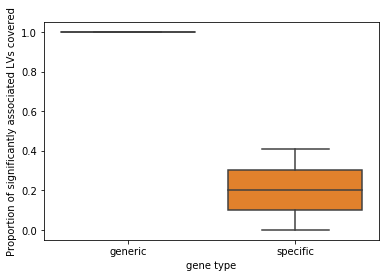

In [15]:
# Plot coverage distribution given list of generic coverage, specific coverage
print(generic_cov)
print(specific_cov)

sns.boxplot(data=gene_cov, x='gene type', y='Proportion of significantly associated LVs covered')

In [16]:
# Save plot
fig.savefig(
        output_figure_filename,
        format="svg",
        bbox_inches="tight",
        transparent=True,
        pad_inches=0,
        dpi=300,
    )

NameError: name 'fig' is not defined